In [1]:
import math
from collections import namedtuple
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from tqdm.notebook import tqdm
import random


from numba import jit, vectorize, float64

In [199]:
with open('./data/tsp_51_1', 'r') as input_data_file:
    input_data = input_data_file.read()
    
lines = input_data.split('\n')
nodeCount = int(lines[0])

points = []
for i in range(1, nodeCount+1):
    line = lines[i]
    parts = line.split()
    # points.append(Point(float(parts[0]), float(parts[1])))
    points.append((float(parts[0]), float(parts[1])))
points = np.array(points)

In [257]:
def length(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


def scan_region_from(current_point, remaining_stops):
    x, y = current_point
    
    if x < y:
        x_min = np.min(remaining_stops[:, 0])
        scan_pointer = np.array([x_min, y])
    else:
        y_min = np.min(remaining_stops[:, 1])
        scan_pointer = np.array([x, y_min])

    return scan_pointer


def add_explored(current_stop, remaining_stops):
    ## Add node as explored
    
    # Find the index where the element matches in the array_of_arrays
    remove_idx = np.where(np.all(remaining_stops == current_stop, axis=1))
    
    # Remove the element using the indices
    remaining_stops = np.delete(remaining_stops, remove_idx, axis=0)
    
    return remaining_stops


def point_in_bbox(point, bbox):
    x, y = point
    x_min, y_min, x_max, y_max = bbox
    
    if x_min <= x <= x_max and y_min <= y <= y_max:
        return True
    else:
        return False


def calculate_travel(graph, points):
    path = deepcopy(graph)
    path.append(path[0])
    coordinates = np.array([points[idx] for idx in path])
    distances = np.linalg.norm(coordinates[1:] - coordinates[:-1], axis=1)
    return np.sum(distances)


def get_midpoint(point1, point2):
    return (point1+point2)//2


def do_2opt(path, points, search_idx):
    
    path = deepcopy(path)
    
    coor = np.array([points[idx] for idx in path+[path[0]]])
    dist = np.linalg.norm(coor[1:] - coor[:-1], axis=1)

    ## Sort by n distances set by search_idx
    sorted_dist = np.argsort(-dist) #[:search_idx]

    max_point = np.random.choice(sorted_dist)
    
    mid_point = get_midpoint(coor[max_point], coor[max_point+1])
    
    sorted_neighbor_point = np.argsort(length_distance(mid_point, points))[:search_idx]
    neighbor_point = np.random.choice(sorted_neighbor_point)
    
    switch_point = np.where((coor == points[neighbor_point]).all(axis=1))[0][0]

    if switch_point > max_point:
        slice_start = max_point
        slice_end = switch_point
    else:
        slice_start = switch_point
        slice_end = max_point

    slice_path = path[slice_start:slice_end+1]
    slice_path.reverse()

    new_path = path[:slice_start]+slice_path+path[slice_end+1:]
    
    return new_path

In [258]:
@jit(nopython=True)
def length_distance(single_point, all_points):
    return np.sqrt((all_points[:, 0]-single_point[0])**2 + (all_points[:, 1]-single_point[1])**2)

In [253]:
# exploring_path = []
# explore_points = deepcopy(points)
# global_bbox = np.array([min(points[:, 0]), min(points[:, 1]), max(points[:, 0]), max(points[:, 1])])

# mid_x, mid_y = (global_bbox[2]-global_bbox[0])//2, (global_bbox[3]-global_bbox[1])//2
# base_distance = np.sqrt((points[:, 0])**2 + (points[:, 1])**2)

In [254]:
# optimal_path = []
# optimal_distance = float('inf')

# for _ in tqdm(range(10)):
    
#     exploring_path = []
#     explore_points = deepcopy(points)
#     max_neighbors = 2 #len(points)//10
    
#     pick_next = 0
#     exploring_path.append(pick_next)
#     while len(exploring_path) < len(points):
    
#         one_point = points[pick_next]
        
#         neighbor_distances = length_distance(one_point, explore_points)
#         neighbor_idx = np.argsort(neighbor_distances)
        
#         mask = np.isin(neighbor_idx, exploring_path)
#         neighbor_idx = neighbor_idx[~mask]
    
#         pick_next = np.random.choice(neighbor_idx[:max_neighbors])
    
#         exploring_path.append(pick_next)

#     total_distance = calculate_travel(exploring_path, points)

#     if total_distance < optimal_distance:
#         optimal_path = deepcopy(exploring_path)
#         optimal_distance = total_distance




# global_optimal_path = deepcopy(optimal_path)
# global_optimal_distance = deepcopy(optimal_distance)

# optimal_distance

In [222]:

starting_path = list(range(len(points)))
random.shuffle(starting_path)
starting_distance = calculate_travel(starting_path, points)

In [259]:
global_optimal_path = deepcopy(starting_path)
global_optimal_distance = deepcopy(starting_distance)

starting_distance

1640.3846169176572

In [ ]:
iter = 0
max_iterations = 500000

init_temperature = 1000
final_temperature = 1e-9
cooling_rate = 0.999
search_idx = len(points)

temperature = init_temperature

restart_counter = 0
last_known_distance = int(global_optimal_distance)

with tqdm() as pbar:    
    
    while temperature > final_temperature and iter < max_iterations:
        
        search_idx = len(points)
    
        optimal_path = deepcopy(global_optimal_path)
        optimal_distance = deepcopy(global_optimal_distance)
    
        idx_i, idx_j = random.sample(range(len(optimal_path)), 2)
        optimal_path[idx_i], optimal_path[idx_j] = optimal_path[idx_j], optimal_path[idx_i]
        optimal_distance = calculate_travel(optimal_path, points)
    
        
        while search_idx >= 1:
                
            new_path = do_2opt(optimal_path, points, search_idx)
            new_distance = calculate_travel(new_path, points)
            
            if new_distance <= optimal_distance:
                optimal_distance = deepcopy(new_distance)
                optimal_path = deepcopy(new_path)
                
            else:
                acceptance_prob = np.exp(-(new_distance-optimal_distance)/temperature)
                to_pick_prob = random.random()
                
                if to_pick_prob < acceptance_prob:
                    # print(to_pick_prob, acceptance_prob, new_distance-optimal_distance)
                    optimal_distance = deepcopy(new_distance)
                    optimal_path = deepcopy(new_path)
            
                
            if optimal_distance < global_optimal_distance:
                global_optimal_distance = deepcopy(optimal_distance)
                global_optimal_path = deepcopy(optimal_path)

            
            pbar.update(1)
            iter+=1
            search_idx = int(search_idx//1.2)
            # search_idx = int(search_idx//2)


            if iter%1000 == 0:
                print(search_idx, iter, global_optimal_distance, temperature)

        
        if int(global_optimal_distance) < last_known_distance:
            last_known_distance = int(global_optimal_distance)
            restart_counter = 0
        else:
            restart_counter += 1


        if restart_counter > 10 and temperature < init_temperature:
            temperature *= 1.001
            restart_counter = 0
        else:
            temperature *= cooling_rate


        
    

0it [00:00, ?it/s]

10 1000 1118.7411426945835 943.6206764838763
0 2000 946.8030160937383 892.2026036726493
10 3000 884.7523715608407 844.4298978858477
0 4000 875.4032637742506 800.0151816789139
10 5000 875.4032637742506 760.2134032162132
0 6000 852.0964597269049 720.2282456026684
10 7000 837.3441794755807 683.0285447387486
0 8000 829.8712256558107 648.3986024806333


In [135]:
459, 435.93

1001.94727

In [ ]:
# iter = 0
# max_iterations = 50000

init_temperature = 1000
final_temperature = 1e-9
cooling_rate = 0.999
search_idx = len(points)


while search_idx >= 1:
    
    temperature = init_temperature
    optimal_path = deepcopy(global_optimal_path)
    optimal_distance = deepcopy(global_optimal_distance)
    
    # idx_i, idx_j = random.sample(range(len(optimal_path)), 2)
    # optimal_path[idx_i], optimal_path[idx_j] = optimal_path[idx_j], optimal_path[idx_i]
    random.shuffle(optimal_path)
    optimal_distance = calculate_travel(optimal_path, points)
    
    with tqdm(leave=False) as pbar:
        while temperature > final_temperature:
            
            new_path = do_2opt(optimal_path, points, search_idx)
            new_distance = calculate_travel(new_path, points)
            
            if new_distance <= optimal_distance:
                optimal_distance = deepcopy(new_distance)
                optimal_path = deepcopy(new_path)
                
            else:
                acceptance_prob = np.exp(-(new_distance-optimal_distance)/temperature)
                to_pick_prob = random.random()
                
                if to_pick_prob < acceptance_prob:
                    # print(to_pick_prob, acceptance_prob, new_distance-optimal_distance)
                    optimal_distance = deepcopy(new_distance)
                    optimal_path = deepcopy(new_path)
        
                
            if optimal_distance < global_optimal_distance:
                global_optimal_distance = deepcopy(optimal_distance)
                global_optimal_path = deepcopy(optimal_path)
               
    
            temperature *= cooling_rate
            pbar.update(1)
    
    search_idx = int(search_idx//1.25)
    print(search_idx, global_optimal_distance)

In [ ]:
1//1.25

In [245]:
# edge_x = []
# edge_y = []

# for idx, connections in tqdm(enumerate(graph_paths)):
    
#     x0, y0 = points[idx]
    
#     for connect in connections:
#         x1, y1 = points[connect]
    
#         edge_x.append(x0)
#         edge_x.append(x1)
#         edge_x.append(None)
        
#         edge_y.append(y0)
#         edge_y.append(y1)
#         edge_y.append(None)

edge_x = []
edge_y = []

for idx in tqdm(global_optimal_path + [global_optimal_path[0]]):
    
    x0, y0 = points[idx]
    
    edge_x.append(x0)
    edge_y.append(y0)

  0%|          | 0/52 [00:00<?, ?it/s]

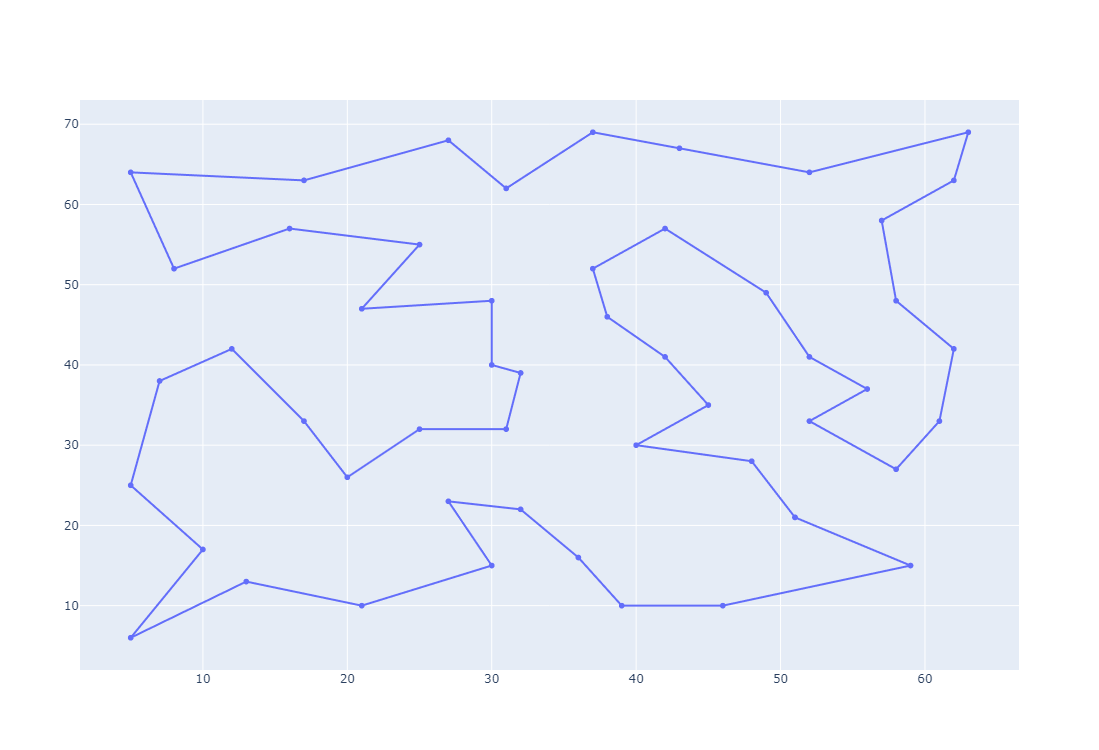

In [246]:


fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


In [ ]:


fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


In [ ]:
fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

In [ ]:

x_points = [x for x, y in points]
y_points = [y for x, y in points]
layout_ratio = max(x_points)/max(y_points)

fig = go.Figure(data=go.Scattergl(
    x=x_points,
    y=y_points,
    # mode="markers+lines",
    mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

In [ ]:

x_points = [x for x, y in exploring_path]
y_points = [y for x, y in exploring_path]
layout_ratio = max(x_points)/max(y_points)

fig = go.Figure(data=go.Scattergl(
    x=x_points,
    y=y_points,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

In [ ]:
# SEMI-MST

# edge_x = []
# edge_y = []

# for one_point in tqdm(points):

#     neighbors = np.sqrt((points[:, 0]-one_point[0])**2 + (points[:, 1]-one_point[1])**2)
    
#     x0, y0 = one_point

#     connections = points[np.argsort(neighbors)[1]] # [1:3]] ## 2 connections - 1st one is self
    
#     for connect in [connections]:
#         x1, y1 = connect
    
#         edge_x.append(x0)
#         edge_x.append(x1)
#         edge_x.append(None)
        
#         edge_y.append(y0)
#         edge_y.append(y1)
#         edge_y.append(None)


# fig = go.Figure(data=go.Scattergl(
#     x=edge_x,
#     y=edge_y,
#     mode="markers+lines",
#     # mode="markers"
# ))
# fig.update_layout(width=1200, height=1200*layout_ratio)
# fig.show()




# def do_2opt(path, points, search_idx):
    
#     path = deepcopy(path)
    
#     coor = np.array([points[idx] for idx in path+[path[0]]])
#     dist = np.linalg.norm(coor[1:] - coor[:-1], axis=1)

#     ## This coordinate has longest distance
#     max_point = np.argsort(-dist)[search_idx]

#     mid_point = get_midpoint(coor[max_point], coor[max_point+1])
#     mid_nearest_point = np.argmin(length_distance(mid_point, points))
#     switch_point = np.where((coor == points[mid_nearest_point]).all(axis=1))[0][0]

#     if switch_point > max_point:
#         slice_start = max_point
#         slice_end = switch_point
#     else:
#         slice_start = switch_point
#         slice_end = max_point

#     slice_path = path[slice_start:slice_end+1]
#     slice_path.reverse()

#     new_path = path[:slice_start]+slice_path+path[slice_end+1:]
    
#     return new_path
